<a href="https://colab.research.google.com/github/DJCordhose/transformers/blob/main/notebooks/Bunny_Llama_3_8B_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bunny: lightweight but powerful multimodal models

https://huggingface.co/BAAI/Bunny-Llama-3-8B-V

Bunny-Llama-3-8B-V is built upon https://huggingface.co/google/siglip-so400m-patch14-384 (CLIP, a multimodal model, with a better loss function) and https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct.

## GPU >= L4 having 24GB

Does not run on a T4, even though Llama-3-8B would do with 16GB as we have the additional SigLIP. Works on the L4 having 24GB, though.

## watch nvidia-smi

You might want to run `watch nvidia-smi` in a Terminal below this notebook to see how

memory
utilization (shown as percentage) and
temperature
develop when executing this.

In [1]:
!nvidia-smi

Sat May  4 10:30:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   64C    P0              23W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -q torch transformers accelerate pillow

In [3]:
!wget https://huggingface.co/BAAI/Bunny-Llama-3-8B-V/resolve/main/images/images_example_2.png?download=true -O example_2.png

--2024-05-04 10:30:08--  https://huggingface.co/BAAI/Bunny-Llama-3-8B-V/resolve/main/images/images_example_2.png?download=true
Resolving huggingface.co (huggingface.co)... 18.155.68.4, 18.155.68.111, 18.155.68.124, ...
Connecting to huggingface.co (huggingface.co)|18.155.68.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74589 (73K) [image/png]
Saving to: ‘example_2.png’

example_2.png       100%[===================>]  72.84K  --.-KB/s    in 0.002s  

2024-05-04 10:30:08 (39.5 MB/s) - ‘example_2.png’ saved [74589/74589]



In [10]:
!wget https://huggingface.co/BAAI/Bunny-Llama-3-8B-V/resolve/main/images/images_example_1.png?download=true -O example_1.png

--2024-05-04 10:33:59--  https://huggingface.co/BAAI/Bunny-Llama-3-8B-V/resolve/main/images/images_example_1.png?download=true
Resolving huggingface.co (huggingface.co)... 18.155.68.111, 18.155.68.4, 18.155.68.124, ...
Connecting to huggingface.co (huggingface.co)|18.155.68.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244967 (239K) [image/png]
Saving to: ‘example_1.png’

example_1.png       100%[===================>] 239.23K  1015KB/s    in 0.2s    

2024-05-04 10:33:59 (1015 KB/s) - ‘example_1.png’ saved [244967/244967]



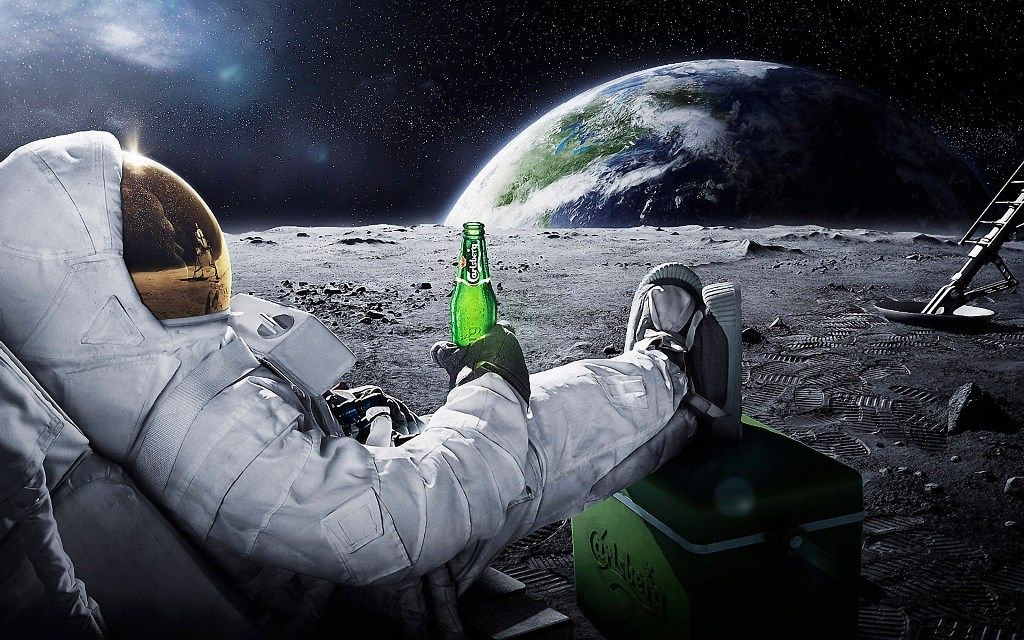

In [17]:
from PIL import Image

image1 = Image.open('example_1.png')
image1

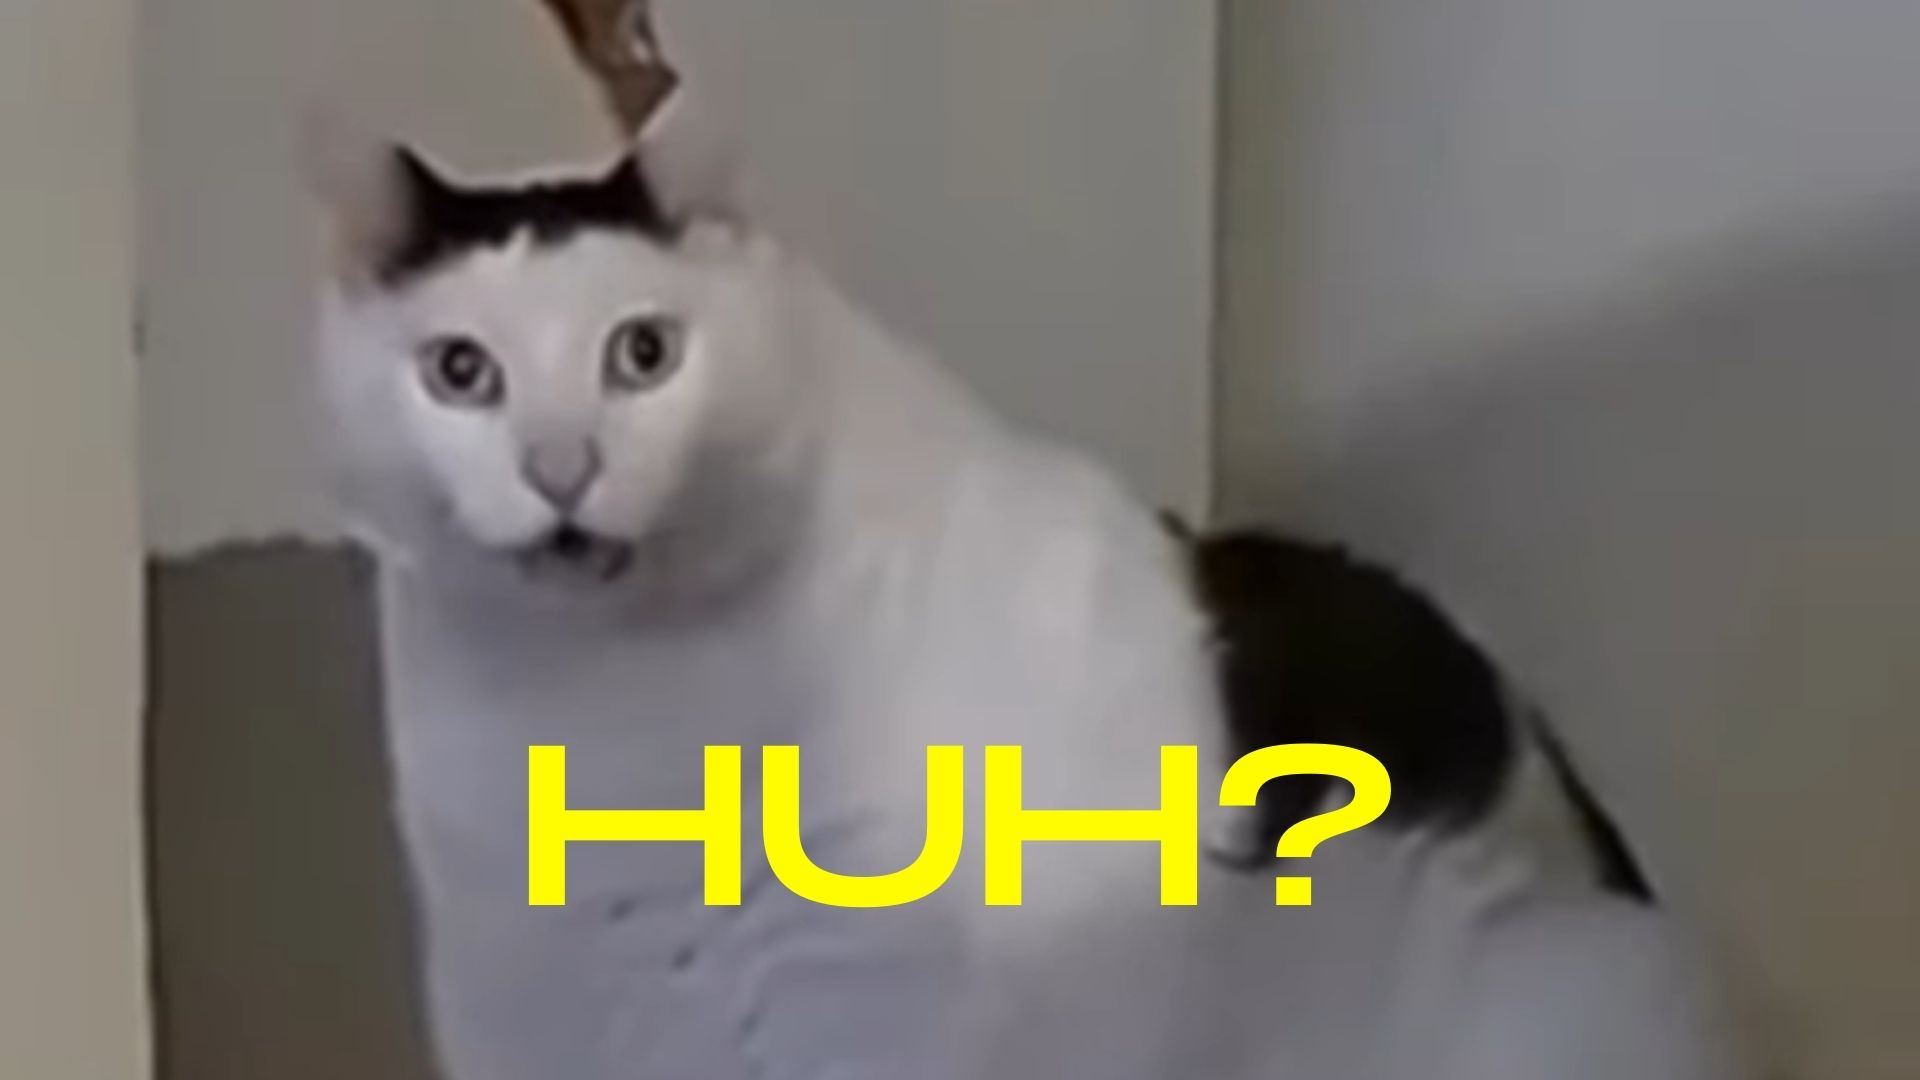

In [18]:
image2 = Image.open('example_2.png')
image2

In [5]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import warnings

warnings.filterwarnings('ignore')
model_id = "BAAI/Bunny-Llama-3-8B-V"

# set device
device = 'cuda'  # or cpu
torch.set_default_device(device)

# create model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16, # float32 for cpu
    device_map='auto',
    trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at BAAI/Bunny-Llama-3-8B-V were not used when initializing BunnyLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.encoder.layers.26.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.mlp.fc2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.self_attn.k_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.self_attn.k_proj.weight', 'model.vision_tower.vision_tower.vision_model.

In [19]:
image = image1

# text prompt
prompt = 'Why is the image funny?'
text = f"A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: <image>\n{prompt} ASSISTANT:"
text_chunks = [tokenizer(chunk).input_ids for chunk in text.split('<image>')]
input_ids = torch.tensor(text_chunks[0] + [-200] + text_chunks[1][1:], dtype=torch.long).unsqueeze(0).to(device)

image_tensor = model.process_images([image], model.config).to(dtype=model.dtype, device=device)

# generate
output_ids = model.generate(
    input_ids,
    images=image_tensor,
    max_new_tokens=100,
    use_cache=True)[0]

print(tokenizer.decode(output_ids[input_ids.shape[1]:], skip_special_tokens=True).strip())

The image is funny because it depicts a surreal scene of an astronaut sitting on the moon, relaxing with a beer. It's an unexpected and humorous juxtaposition of a typical leisure activity with the extraordinary environment of space.


In [20]:
image = image2

# text prompt
prompt = 'Why is the image funny?'
text = f"A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: <image>\n{prompt} ASSISTANT:"
text_chunks = [tokenizer(chunk).input_ids for chunk in text.split('<image>')]
input_ids = torch.tensor(text_chunks[0] + [-200] + text_chunks[1][1:], dtype=torch.long).unsqueeze(0).to(device)

image_tensor = model.process_images([image], model.config).to(dtype=model.dtype, device=device)

# generate
output_ids = model.generate(
    input_ids,
    images=image_tensor,
    max_new_tokens=100,
    use_cache=True)[0]

print(tokenizer.decode(output_ids[input_ids.shape[1]:], skip_special_tokens=True).strip())

The image is funny because it features a cat with a surprised expression, as if it's asking a question. The yellow text "Huh?" is placed on the cat, which adds to the comedic effect.
